# Fashion MNIST classification

Model trained on google colab

### Imports

In [21]:
import os
import torch
import torchvision
import tarfile
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd

import seaborn as sns

### Dataset Class

In [2]:
# create class data that holds fashion mnist data
class Data(Dataset):
    def __init__(self, test=False, val=False, final=False, transform=None):
        self.transform = transform
        data = np.load(file = f"fashion_{'test' if test else 'train'}.npy")

        # split to x and y
        images, targets = data[:, :-1], data[:, -1]
        
        if not (test or final):
            # split train to train and validation
            images, val_x, targets, val_y = train_test_split(images, targets, test_size=0.2, random_state=42)

            if val:
                images = val_x
                targets = val_y
        
        # convert to tensors
        self.images = torch.from_numpy(images).reshape(-1, 1, 28, 28).float()
        self.targets = torch.from_numpy(targets).long()
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      img, target = self.images[idx], self.targets[idx]
      if self.transform:
        img = self.transform(img)
      return img, target

### CNN Model class

In [3]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding="same"), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(3), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes)
                                        )
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

class ConvNet(nn.Module):
    def __init__(self, in_channels, num_classes, dropout=0.2):
        super().__init__()
        self.conv1 = conv_block(1, 16)
        self.conv2 = conv_block(16, 32)
        self.conv2 = conv_block(32, 16)

        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(dropout),
                                        nn.Linear(784, num_classes)
                                        )
    
    def forward(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = self.conv3(X)
        X = self.classifier(X)
        return X

### Evaluation Helper Function

In [4]:
def dataset_eval(data_loader, model, criterion, device):
    loss = []
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            _, predicted = torch.max(preds.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss.append(criterion(preds, labels).item())

    accuracy = correct / total

    return accuracy, np.mean(loss)

### Loading the data/data augmentation/normalization

In [5]:
train, test = np.load(file="fashion_train.npy"), np.load(file="fashion_test.npy")
X, y = train[:, :-1], train[:, -1]

# get mean and std of data
train_mean = np.mean(X)
train_std = np.std(X)

# Data Augmentation and normalization for train and val
train_stats = (train_mean, train_std)
train_transformer = tt.Compose([tt.RandomCrop(28, padding=2, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.Normalize(*train_stats,inplace=True)
                         ])
validation_transformer = tt.Compose([tt.Normalize(*train_stats)])

# Data augmentation and normalization for total trainset and test
total = np.concatenate((train, test))
X, y = total[:, :-1], total[:, -1]
total_mean = np.mean(X)
total_std = np.std(X)

total_stats = (total_mean, total_std)
total_transformer = tt.Compose([tt.RandomCrop(28, padding=2, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.Normalize(*total_stats,inplace=True)
                         ])
test_transformer = tt.Compose([tt.Normalize(*total_stats)])

CPU optimization by: https://jovian.ai/aakashns/05b-cifar10-resnet#C25

In [6]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [7]:
# Device configuration
device = get_default_device()
print(device)

# Hyper-parameters
EPOCHS = 50
BATCH_SIZE = 400
WEIGHT_DECAY = 0.0005
MAX_LEARNING_RATE = 0.01

# Load data into dataset objects
train = Data(transform=train_transformer)
val = Data(val=True, transform=validation_transformer)
test = Data(test=True, transform=validation_transformer)
final = Data(final=True, transform=total_transformer)

# Data loader
train_loader = DataLoader(dataset=train, batch_size=BATCH_SIZE, shuffle=True, num_workers=3, pin_memory=True)
val_loader = DataLoader(dataset=val, batch_size=BATCH_SIZE, shuffle=False, num_workers=3, pin_memory=True)
test_loader = DataLoader(dataset=test, batch_size=BATCH_SIZE, shuffle=False, num_workers=3, pin_memory=True)
final_loader = DataLoader(dataset=final, batch_size=BATCH_SIZE, shuffle=False, num_workers=3, pin_memory=True)

# DeviceDataLoaders
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)
final_loader = DeviceDataLoader(final_loader, device)

cuda


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Model initialization

In [8]:
# Initialize model
model = ResNet9(1, 5).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=MAX_LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, MAX_LEARNING_RATE, epochs=EPOCHS, 
                                                steps_per_epoch=len(train_loader))

### Training

In [9]:
total_step = len(train_loader)
loss_hist_train = []
loss_hist_val = []
acc_hist_train = []
acc_hist_val = []
for epoch in range(EPOCHS):
    train_loss = []
    total_train = 0
    correct_train = 0
    for images, labels in train_loader:
        # Move tensors to the configured device
        images = to_device(images, device)
        labels = to_device(labels, device)

        # Forward pass
        preds = model(images)
        _, predicted = torch.max(preds.data, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        loss = criterion(preds, labels)
        train_loss.append(loss.item())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update learning rate
        scheduler.step()
            
    # calculate epoch train and test metrics
    train_accuracy = correct_train / total_train
    acc_hist_train.append(train_accuracy)
    train_loss = sum(train_loss) / len(train_loss)
    loss_hist_train.append(train_loss)
    val_accuracy, val_loss = dataset_eval(val_loader, model, criterion, device)
    acc_hist_val.append(val_accuracy)
    loss_hist_val.append(val_loss)

    print(f'Epoch [{epoch + 1}/{EPOCHS}]{"": >30}\nTrain Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}\nTrain Accuracy: {train_accuracy:.2%} - Val Accuracy: {val_accuracy:.2%}')
    
  

Epoch [1/50]                              
Train Loss: 0.8877 - Val Loss: 0.6014
Train Accuracy: 67.34% - Val Accuracy: 76.00%
Epoch [2/50]                              
Train Loss: 0.5336 - Val Loss: 0.4849
Train Accuracy: 79.20% - Val Accuracy: 82.35%
Epoch [3/50]                              
Train Loss: 0.4426 - Val Loss: 0.4276
Train Accuracy: 83.33% - Val Accuracy: 83.15%
Epoch [4/50]                              
Train Loss: 0.3971 - Val Loss: 0.4252
Train Accuracy: 84.80% - Val Accuracy: 83.80%
Epoch [5/50]                              
Train Loss: 0.4028 - Val Loss: 0.4867
Train Accuracy: 84.47% - Val Accuracy: 82.95%
Epoch [6/50]                              
Train Loss: 0.3857 - Val Loss: 0.3864
Train Accuracy: 85.46% - Val Accuracy: 85.55%
Epoch [7/50]                              
Train Loss: 0.3480 - Val Loss: 0.4338
Train Accuracy: 86.36% - Val Accuracy: 83.45%
Epoch [8/50]                              
Train Loss: 0.3355 - Val Loss: 0.4320
Train Accuracy: 87.40% - Val A

### Plotting train/validation loss/accuracy

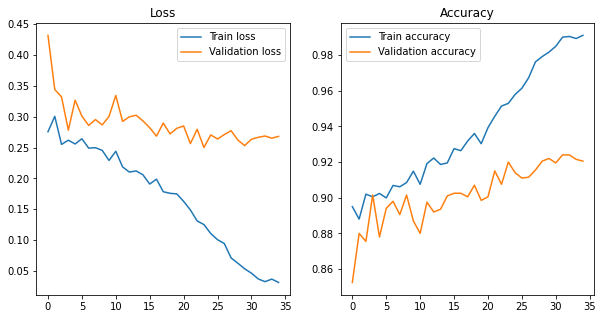

In [10]:
fig = plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_hist_train[15:], label="Train loss")
plt.plot(loss_hist_val[15:], label="Validation loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_hist_train[15:], label="Train accuracy")
plt.plot(acc_hist_val[15:], label="Validation accuracy")
plt.title("Accuracy")
plt.legend() 
plt.show()

### Train and Validation accuracy calc

In [11]:
acc, loss = dataset_eval(val_loader, model, criterion, device)
print(f'Accuracy of the model on the 8000 train images: {acc:.3%}%')
print(f'Loss of the model on the 2000 train images: {loss:.5f}')

acc, loss = dataset_eval(train_loader, model, criterion, device)
print(f'Accuracy of the model on the 8000 train images: {acc:.3%}')
print(f'Loss of the model on the 2000 train images: {loss:.5f}')

Accuracy of the model on the 8000 train images: 92.400%%
Loss of the model on the 2000 train images: 0.26418
Accuracy of the model on the 8000 train images: 99.050%
Loss of the model on the 2000 train images: 0.03382


## Final results on Test data

In [8]:
# Initialize model
model_final = ResNet9(1, 5).to(device)

# Loss and optimizer
criterion_final = nn.CrossEntropyLoss()
optimizer_final = torch.optim.Adam(model_final.parameters(), lr=MAX_LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# learning rate scheduler
scheduler_final = torch.optim.lr_scheduler.OneCycleLR(optimizer_final, MAX_LEARNING_RATE, epochs=EPOCHS, 
                                                steps_per_epoch=len(final_loader))

In [9]:
total_step = len(final_loader)
loss_hist_total = []
acc_hist_total = []

for epoch in range(EPOCHS):
    total_loss = []
    total_count = 0
    correct = 0
    for images, labels in final_loader:
        # Move tensors to the configured device
        images = to_device(images, device)
        labels = to_device(labels, device)

        # Forward pass
        preds = model_final(images)
        _, predicted = torch.max(preds.data, 1)
        correct += (predicted == labels).sum().item()
        total_count += labels.size(0)
        loss = criterion_final(preds, labels)
        total_loss.append(loss.item())

        # Backward and optimize
        optimizer_final.zero_grad()
        loss.backward()
        optimizer_final.step()

        # update learning rate
        scheduler_final.step()

    accuracy = correct / total_count
    acc_hist_total.append(accuracy)
    mean_loss = sum(total_loss) / len(total_loss)
    loss_hist_total.append(mean_loss)
            
    print(f'Epoch [{epoch + 1}/{EPOCHS}]{"": >30}\nTrain Loss: {mean_loss:.4f} - Train Accuracy: {accuracy:.2%}')
    
  

Epoch [1/50]                              
Train Loss: 0.9379 - Train Accuracy: 66.26%
Epoch [2/50]                              
Train Loss: 0.5361 - Train Accuracy: 78.82%
Epoch [3/50]                              
Train Loss: 0.4620 - Train Accuracy: 82.16%
Epoch [4/50]                              
Train Loss: 0.4263 - Train Accuracy: 83.26%
Epoch [5/50]                              
Train Loss: 0.4180 - Train Accuracy: 83.92%
Epoch [6/50]                              
Train Loss: 0.3887 - Train Accuracy: 84.84%
Epoch [7/50]                              
Train Loss: 0.3706 - Train Accuracy: 85.78%
Epoch [8/50]                              
Train Loss: 0.3476 - Train Accuracy: 86.62%
Epoch [9/50]                              
Train Loss: 0.3279 - Train Accuracy: 87.41%
Epoch [10/50]                              
Train Loss: 0.3368 - Train Accuracy: 87.35%
Epoch [11/50]                              
Train Loss: 0.3292 - Train Accuracy: 87.50%
Epoch [12/50]                            

In [10]:
acc, loss = dataset_eval(final_loader, model_final, criterion_final, device)
print(f'Accuracy of the model on the 10000 train images: {acc:.3%}')
print(f'Loss of the model on the 10000 train images: {loss:.5f}')

print()

acc, loss = dataset_eval(test_loader, model_final, criterion_final, device)
print(f'Accuracy of the model on the 5000 test images: {acc:.3%}')
print(f'Loss of the model on the 5000 test images: {loss:.5f}')

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy of the model on the 10000 train images: 99.050%
Loss of the model on the 10000 train images: 0.03381

Accuracy of the model on the 5000 test images: 91.040%
Loss of the model on the 5000 test images: 0.30737


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


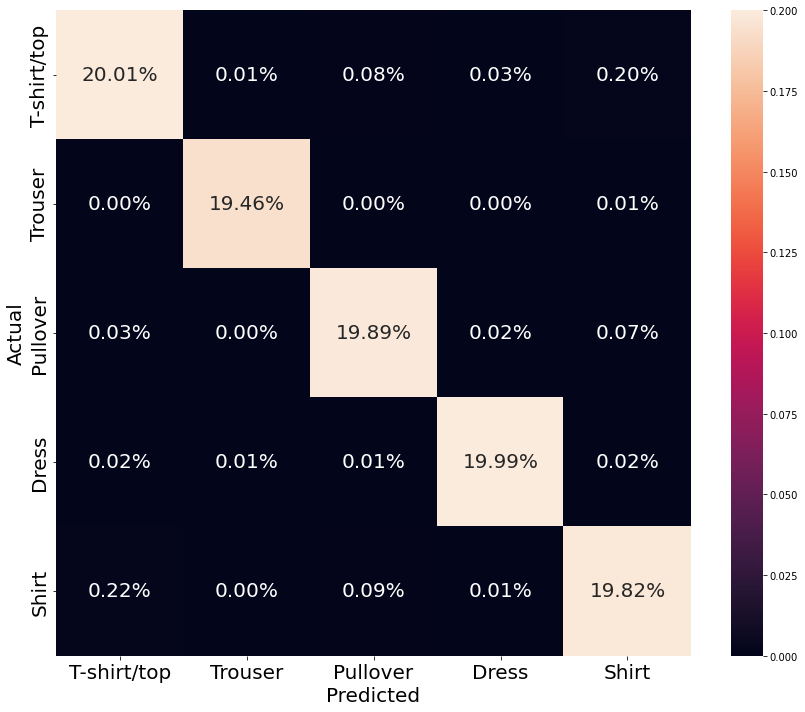

In [32]:
classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Shirt"]
# plot confusion matrix from model_final

target = to_device(torch.tensor([]), device)
preds = to_device(torch.tensor([]), device)

model_final.eval()
for images, labels in final_loader:
    images = to_device(images, device)
    labels = to_device(labels, device)
    pred = model_final(images).max(1).indices
    target = torch.concat([target, labels])
    preds = torch.concat([preds, pred])

target = target.tolist()
preds = preds.tolist()

cm = confusion_matrix(target, preds)

cm = cm.astype('float') / cm.sum()
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='.2%', xticklabels=classes, yticklabels=classes, annot_kws={"size":20})
plt.ylabel('Actual', fontsize=20)
plt.xlabel('Predicted', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
plt.savefig('cm_cnn.png')

### Saving of the model

In [28]:
PATH = f"model_final.pth"

torch.save(model_final.state_dict(), PATH)